In [2]:
#Instalar pyarrow
!pip install pyarrow

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install lightgbm

In [ ]:
import pandas as pd

# Leer el archivo Parquet
df = pd.read_parquet("data_input.parquet")

# Visualizar las primeras filas
df.head()

,ANIOCAMPANAPROCESO,ANIOCAMPANA,CODEBELISTA,CODTERRITORIO,CODCOMPORTAMIENTOROLLING,EDAD,FLAGCORREOVALIDADO,FLAGCELULAR,FLAGDIGITAL,DESESTADOCIVIL_CAT,...,DESVIACION_REMESA,FLAGNUEVA,FLAG18,FLAG19,FLAG20,DESV_PEDMIN,DESV_PEDMIN_ADJ,CLASE,TARGET_COBRANZA31_CA,PROM_DIAS_PAGO
0,202414,202410,052370302,57947,1,43,0,1,0,5,...,0.00000,1,0,0,0,224.06000,224.06000,1,1,189.00000
1,202414,202410,049033176,7361,1,31,0,1,0,5,...,0.00000,1,0,0,0,15.86000,15.86000,0,1,189.00000
2,202414,202410,052453461,5033,1,27,0,1,0,5,...,0.00000,1,0,0,0,374.16000,374.16000,1,1,189.00000
3,202414,202410,052363101,32437,1,71,0,1,0,5,...,0.00000,1,0,0,0,51.76000,51.76000,1,1,189.00000
4,202414,202410,052416760,27765,1,29,0,1,0,5,...,0.00000,1,0,0,0,67.67000,67.67000,1,1,189.00000


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import resample

import lightgbm as lgbm
import warnings
warnings.filterwarnings('ignore')


In [6]:
# EDA 

In [8]:
print("Dimensiones:", df.shape)
print("\n Columnas:\n", df.columns)
print("\n Tipos de datos:\n", df.dtypes)
print("\n Valores nulos:\n", df.isnull().sum())
print("\n Primeras filas:\n", df.head())

Dimensiones: (99172, 87)

 Columnas:
 Index(['ANIOCAMPANAPROCESO', 'ANIOCAMPANA', 'CODEBELISTA', 'CODTERRITORIO',
       'CODCOMPORTAMIENTOROLLING', 'EDAD', 'FLAGCORREOVALIDADO', 'FLAGCELULAR',
       'FLAGDIGITAL', 'DESESTADOCIVIL_CAT', 'NRO_PEDIDOS', 'NRO_PEDIDOS_U6C',
       'NRO_PEDIDOS_U18C', 'CANALINGRESO_CAT', 'REALVTAMNFACTURA', 'CODZONA_X',
       'CODREGION', 'EDADBINS', 'PROMEDIOFACTURAS', 'MAXFACTURA', 'MINFACTURA',
       'RATIOFACTURAS', 'REGLA_REVISTA', 'REGLA_CATALOGO', 'REGLA_WEB',
       'REGLA_OTROS', 'LBEL', 'ESIKA', 'CYZONE', 'ANIOCAMPANAINGRESO',
       'GANANCIA_TOTAL', 'DIA_VENC', 'FLAGQUINCENA', 'FLAGINIFIN',
       'ANTIGUEDAD', 'FRAGANCIAS', 'CORPORAL', 'FACIAL', 'PERSONAL',
       'CAMPANAINGRESO', 'DESNIVELSOCIA', 'DESRENDIMIENTOSOCIA',
       'TOTAL_FACTURAS', 'FACTURAS_DEUDA_21_CA', 'FACTURAS_DEUDA_22_CA',
       'FACTURAS_DEUDA_23_CA', 'FACTURAS_DEUDA_24_CA', 'FACTURAS_DEUDA_25_CA',
       'FACTURAS_DEUDA_26_CA', 'FACTURAS_DEUDA_31_CA', 'FACTURAS_DEUDA_4

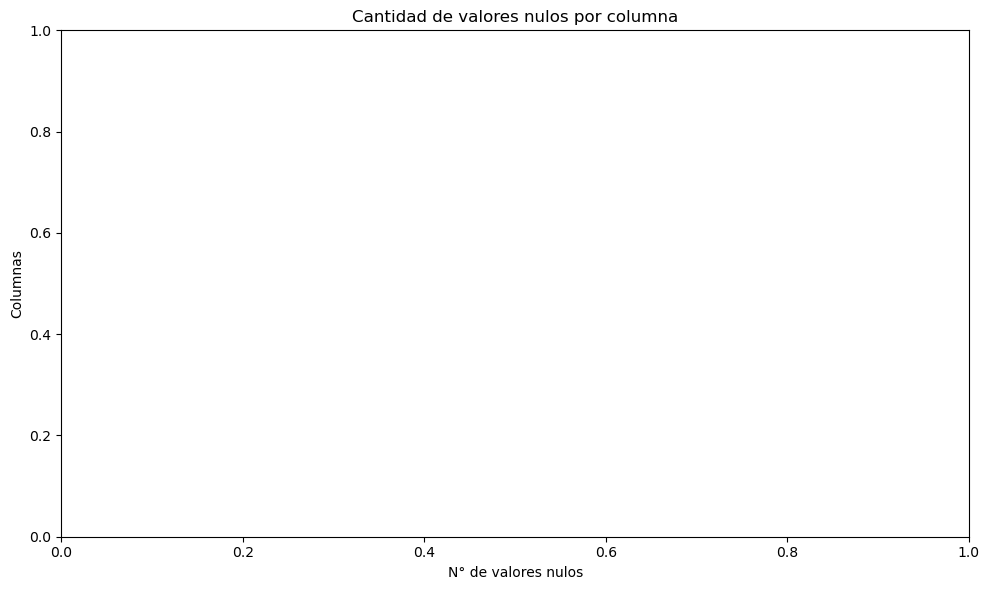

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular nulos
null_counts = df.isnull().sum()
null_counts = null_counts[null_counts > 0].sort_values(ascending=False)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=null_counts.values, y=null_counts.index, palette="viridis")
plt.title("Cantidad de valores nulos por columna")
plt.xlabel("N° de valores nulos")
plt.ylabel("Columnas")
plt.tight_layout()
plt.show()


In [12]:
# Convertir nombres de columnas a minúsculas
df.columns = df.columns.str.lower()

In [13]:
# Balance de la categoría Y
df['clase'].value_counts(normalize=True)

clase
0    0.761778
1    0.238222
Name: proportion, dtype: float64

In [14]:
# ========================
# Preprocesamiento
# ========================

# Filtro específico
dataset = df[df.target_cobranza31_ca == 1]

# Reemplazo y conversión de tipos
dataset = dataset.fillna(0)
dataset.codzona_x = dataset.codzona_x.replace("", -1)
dataset.codregion = dataset.codregion.replace("", -1)
dataset.codterritorio = dataset.codterritorio.astype(int)
dataset.codzona_x = dataset.codzona_x.astype(int)
dataset.codregion = dataset.codregion.astype(int)
dataset.aniocampanaingreso = dataset.aniocampanaingreso.astype(int)
dataset.campanaingreso = dataset.campanaingreso.astype(int)

In [15]:
# ========================
# Balanceo
# ========================
def target_upsampler(dataset):
    zero_size = dataset.clase.value_counts()[0]
    df_majority = dataset[dataset.clase == 0]
    df_minority = dataset[dataset.clase == 1]

    df_minority_upsampled = resample(
        df_minority,
        replace=True,
        n_samples=(zero_size // 4),
        random_state=123,
    )
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled

df_upsampled = target_upsampler(dataset)

In [ ]:
# ========================
# Split Data
# ========================
X = df_upsampled.drop(["codvendedora", "clase", "aniocampana"], axis=1)
y = df_upsampled["clase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [17]:
print("Valores únicos en y_train:", y_train.unique())
print("Tipo de datos en y_train:", y_train.dtype)

Valores únicos en y_train: [Decimal('0') Decimal('1')]
Tipo de datos en y_train: object


In [18]:
# Asegurar que y_train e y_test sean enteros
y_train = y_train.astype(float).astype(int)
y_test = y_test.astype(float).astype(int)

In [19]:
# Convierte todas las columnas posibles a numéricas 
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Rellena valores faltantes que hayan aparecido
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [20]:
# Construcción del MODELO 1

from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split
import optuna
import pandas as pd

# =============================================
# 1. Optuna para encontrar mejores parámetros LGBM
# =============================================
def objective(trial):
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'n_estimators': 100,
        'random_state': 42
    }

    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    return score

# Ejecutar optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Los mejores parámetros son:", study.best_params)

# ============================
# 2. Evaluar n_estimators múltiples
# ============================
best_params = study.best_params.copy()  # Copia para no modificar directamente

n_estimators_list = [50, 100, 250, 500, 1000]
resultados = []

for n in n_estimators_list:
    best_params['n_estimators'] = n
    model = LGBMClassifier(**best_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[early_stopping(stopping_rounds=200)],
    )
    pred = model.predict(X_test)

    resultados.append({
        'Número de estimadores': f'N={n}',
        'Accuracy': round(accuracy_score(y_test, pred), 4),
        'F1_score': round(f1_score(y_test, pred), 4),
        'Precision': round(precision_score(y_test, pred), 4),
        'Recall': round(recall_score(y_test, pred), 4)
    })

# Mostrar resultados
df_resultados = pd.DataFrame(resultados)
print("\nResultados por número de estimadores:")
print(df_resultados)


[I 2025-05-26 23:41:18,235] A new study created in memory with name: no-name-133544e6-d93e-4ea5-bb0c-99df14005b07


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8738973649068345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8738973649068345
[LightGBM] [Warning] bagging_fraction is set=0.6345356066115276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6345356066115276
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8738973649068345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8738973649068345
[LightGBM] [Warning] bagging_fraction is set=0.6345356066115276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6345356066115276
[LightGBM] [Info] Number of positive: 10634, number of negative: 42248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006079 seconds.
You can

[I 2025-05-26 23:41:22,755] Trial 0 finished with value: 0.48998101836662344 and parameters: {'learning_rate': 0.058593033394375924, 'max_depth': 8, 'num_leaves': 43, 'min_child_samples': 66, 'feature_fraction': 0.8738973649068345, 'bagging_fraction': 0.6345356066115276, 'bagging_freq': 6, 'reg_alpha': 0.26102610033414164, 'reg_lambda': 0.0979795236254386}. Best is trial 0 with value: 0.48998101836662344.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8738973649068345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8738973649068345
[LightGBM] [Warning] bagging_fraction is set=0.6345356066115276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6345356066115276
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.659223202820936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.659223202820936
[LightGBM] [Warning] bagging_fraction is set=0.8655144031440205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8655144031440205
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.659223202820936, colsample_by

[I 2025-05-26 23:41:27,003] Trial 1 finished with value: 0.4949153298295689 and parameters: {'learning_rate': 0.07635005740405154, 'max_depth': 26, 'num_leaves': 42, 'min_child_samples': 85, 'feature_fraction': 0.659223202820936, 'bagging_fraction': 0.8655144031440205, 'bagging_freq': 5, 'reg_alpha': 0.9797960546371784, 'reg_lambda': 0.2636618630630906}. Best is trial 1 with value: 0.4949153298295689.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.659223202820936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.659223202820936
[LightGBM] [Warning] bagging_fraction is set=0.8655144031440205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8655144031440205
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6033025236221016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6033025236221016
[LightGBM] [Warning] bagging_fraction is set=0.9803177020973035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9803177020973035
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6033025236221016, colsample_b

[I 2025-05-26 23:41:31,782] Trial 2 finished with value: 0.43930681403638916 and parameters: {'learning_rate': 0.026469810508382454, 'max_depth': 21, 'num_leaves': 36, 'min_child_samples': 75, 'feature_fraction': 0.6033025236221016, 'bagging_fraction': 0.9803177020973035, 'bagging_freq': 4, 'reg_alpha': 0.6106771090037522, 'reg_lambda': 0.2166704706796978}. Best is trial 1 with value: 0.4949153298295689.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6033025236221016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6033025236221016
[LightGBM] [Warning] bagging_fraction is set=0.9803177020973035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9803177020973035
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8455991767506736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8455991767506736
[LightGBM] [Warning] bagging_fraction is set=0.9050079768526644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9050079768526644
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8455991767506736, colsample

[I 2025-05-26 23:41:35,074] Trial 3 finished with value: 0.4099799088419564 and parameters: {'learning_rate': 0.027512812838005784, 'max_depth': 5, 'num_leaves': 52, 'min_child_samples': 72, 'feature_fraction': 0.8455991767506736, 'bagging_fraction': 0.9050079768526644, 'bagging_freq': 6, 'reg_alpha': 0.9546593885688499, 'reg_lambda': 0.05362901973599199}. Best is trial 1 with value: 0.4949153298295689.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-26 23:41:38,430] Trial 4 finished with value: 0.4817676388619175 and parameters: {'learning_rate': 0.06663555866315271, 'max_depth': 12, 'num_leaves': 27, 'min_child_samples': 51, 'feature_fraction': 0.607488717352287, 'bagging_fraction': 0.6024580918166302, 'bagging_freq': 10, 'reg_alpha': 0.6617393182976465, 'reg_lambda': 0.6472436455434188}. Best is trial 1 with value: 0.4949153298295689.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.607488717352287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.607488717352287
[LightGBM] [Warning] bagging_fraction is set=0.6024580918166302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6024580918166302
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6739971452296967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6739971452296967
[LightGBM] [Warning] bagging_fraction is set=0.9453265053536193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9453265053536193
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6739971452296967, colsample

[I 2025-05-26 23:41:42,921] Trial 5 finished with value: 0.37691978160615525 and parameters: {'learning_rate': 0.015488105400595658, 'max_depth': 10, 'num_leaves': 53, 'min_child_samples': 85, 'feature_fraction': 0.6739971452296967, 'bagging_fraction': 0.9453265053536193, 'bagging_freq': 6, 'reg_alpha': 0.729901914087964, 'reg_lambda': 0.4389425388439281}. Best is trial 1 with value: 0.4949153298295689.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6739971452296967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6739971452296967
[LightGBM] [Warning] bagging_fraction is set=0.9453265053536193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9453265053536193
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7974266257995741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7974266257995741
[LightGBM] [Warning] bagging_fraction is set=0.8810880254411388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8810880254411388
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7974266257995741, colsample

[I 2025-05-26 23:41:47,499] Trial 6 finished with value: 0.5186944366336556 and parameters: {'learning_rate': 0.08651855224194221, 'max_depth': 30, 'num_leaves': 53, 'min_child_samples': 37, 'feature_fraction': 0.7974266257995741, 'bagging_fraction': 0.8810880254411388, 'bagging_freq': 1, 'reg_alpha': 0.9681569803720437, 'reg_lambda': 0.032908502562215}. Best is trial 6 with value: 0.5186944366336556.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7974266257995741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7974266257995741
[LightGBM] [Warning] bagging_fraction is set=0.8810880254411388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8810880254411388
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6656147883628036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6656147883628036
[LightGBM] [Warning] bagging_fraction is set=0.6145025091574635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6145025091574635
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6656147883628036, colsample

[I 2025-05-26 23:41:51,282] Trial 7 finished with value: 0.4877983754088098 and parameters: {'learning_rate': 0.06004550986123514, 'max_depth': 21, 'num_leaves': 39, 'min_child_samples': 45, 'feature_fraction': 0.6656147883628036, 'bagging_fraction': 0.6145025091574635, 'bagging_freq': 2, 'reg_alpha': 0.08490243450371371, 'reg_lambda': 0.12179081376672263}. Best is trial 6 with value: 0.5186944366336556.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6656147883628036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6656147883628036
[LightGBM] [Warning] bagging_fraction is set=0.6145025091574635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6145025091574635
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9792601811494854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9792601811494854
[LightGBM] [Warning] bagging_fraction is set=0.8892907413444289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8892907413444289
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9792601811494854, colsample

[I 2025-05-26 23:41:57,280] Trial 8 finished with value: 0.4830248383865111 and parameters: {'learning_rate': 0.037405280537882925, 'max_depth': 17, 'num_leaves': 56, 'min_child_samples': 30, 'feature_fraction': 0.9792601811494854, 'bagging_fraction': 0.8892907413444289, 'bagging_freq': 3, 'reg_alpha': 0.6554707656649338, 'reg_lambda': 0.00804822465204924}. Best is trial 6 with value: 0.5186944366336556.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9792601811494854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9792601811494854
[LightGBM] [Warning] bagging_fraction is set=0.8892907413444289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8892907413444289
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6255111642057356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6255111642057356
[LightGBM] [Warning] bagging_fraction is set=0.9391810855980575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9391810855980575
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6255111642057356, colsample

[I 2025-05-26 23:42:01,825] Trial 9 finished with value: 0.4345629959297817 and parameters: {'learning_rate': 0.022380520082436472, 'max_depth': 29, 'num_leaves': 48, 'min_child_samples': 20, 'feature_fraction': 0.6255111642057356, 'bagging_fraction': 0.9391810855980575, 'bagging_freq': 5, 'reg_alpha': 0.44701229719254265, 'reg_lambda': 0.23347332128400122}. Best is trial 6 with value: 0.5186944366336556.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6255111642057356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6255111642057356
[LightGBM] [Warning] bagging_fraction is set=0.9391810855980575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9391810855980575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7677179536222242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7677179536222242
[LightGBM] [Warning] bagging_fraction is set=0.7575629536067455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575629536067455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7677179536222242, colsample

[I 2025-05-26 23:42:04,783] Trial 10 finished with value: 0.49481166868193877 and parameters: {'learning_rate': 0.09847050781835417, 'max_depth': 30, 'num_leaves': 24, 'min_child_samples': 38, 'feature_fraction': 0.7677179536222242, 'bagging_fraction': 0.7575629536067455, 'bagging_freq': 1, 'reg_alpha': 0.8166993253904766, 'reg_lambda': 0.9172797007927408}. Best is trial 6 with value: 0.5186944366336556.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7677179536222242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7677179536222242
[LightGBM] [Warning] bagging_fraction is set=0.7575629536067455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575629536067455
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.7479641750991015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7479641750991015
[LightGBM] [Warning] bagging_fraction is set=0.8202493136812269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8202493136812269
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.7479641750991015, colsample

[I 2025-05-26 23:42:09,395] Trial 11 finished with value: 0.5172756131774678 and parameters: {'learning_rate': 0.0867850658641263, 'max_depth': 26, 'num_leaves': 60, 'min_child_samples': 95, 'feature_fraction': 0.7479641750991015, 'bagging_fraction': 0.8202493136812269, 'bagging_freq': 9, 'reg_alpha': 0.994558918283772, 'reg_lambda': 0.44832993827094236}. Best is trial 6 with value: 0.5186944366336556.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.7479641750991015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7479641750991015
[LightGBM] [Warning] bagging_fraction is set=0.8202493136812269, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8202493136812269
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.7599324164974453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7599324164974453
[LightGBM] [Warning] bagging_fraction is set=0.8042682600644669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8042682600644669
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.7599324164974453, colsample

[I 2025-05-26 23:42:14,052] Trial 12 finished with value: 0.5177183937949918 and parameters: {'learning_rate': 0.09579515105116977, 'max_depth': 25, 'num_leaves': 58, 'min_child_samples': 97, 'feature_fraction': 0.7599324164974453, 'bagging_fraction': 0.8042682600644669, 'bagging_freq': 9, 'reg_alpha': 0.8569731453171032, 'reg_lambda': 0.5617955328648299}. Best is trial 6 with value: 0.5186944366336556.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.7599324164974453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7599324164974453
[LightGBM] [Warning] bagging_fraction is set=0.8042682600644669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8042682600644669
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8259017309102592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8259017309102592
[LightGBM] [Warning] bagging_fraction is set=0.7231959367902172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231959367902172
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8259017309102592, colsample

[I 2025-05-26 23:42:19,017] Trial 13 finished with value: 0.5255313010168573 and parameters: {'learning_rate': 0.09562585058946195, 'max_depth': 24, 'num_leaves': 60, 'min_child_samples': 19, 'feature_fraction': 0.8259017309102592, 'bagging_fraction': 0.7231959367902172, 'bagging_freq': 8, 'reg_alpha': 0.8353237655274858, 'reg_lambda': 0.6788665463642329}. Best is trial 13 with value: 0.5255313010168573.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8259017309102592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8259017309102592
[LightGBM] [Warning] bagging_fraction is set=0.7231959367902172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7231959367902172
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8961589639674382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8961589639674382
[LightGBM] [Warning] bagging_fraction is set=0.7094502419157096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7094502419157096
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8961589639674382, colsample

[I 2025-05-26 23:42:23,557] Trial 14 finished with value: 0.5098178864221636 and parameters: {'learning_rate': 0.07807065127337136, 'max_depth': 22, 'num_leaves': 50, 'min_child_samples': 11, 'feature_fraction': 0.8961589639674382, 'bagging_fraction': 0.7094502419157096, 'bagging_freq': 8, 'reg_alpha': 0.4385689330866954, 'reg_lambda': 0.81467097611692}. Best is trial 13 with value: 0.5255313010168573.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8961589639674382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8961589639674382
[LightGBM] [Warning] bagging_fraction is set=0.7094502419157096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7094502419157096
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.94079850350573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.94079850350573
[LightGBM] [Warning] bagging_fraction is set=0.7058186471716692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7058186471716692
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.94079850350573, colsample_bytre

[I 2025-05-26 23:42:27,491] Trial 15 finished with value: 0.49952608165193035 and parameters: {'learning_rate': 0.08585231864782569, 'max_depth': 16, 'num_leaves': 32, 'min_child_samples': 28, 'feature_fraction': 0.94079850350573, 'bagging_fraction': 0.7058186471716692, 'bagging_freq': 8, 'reg_alpha': 0.8190614853317885, 'reg_lambda': 0.7189310884695302}. Best is trial 13 with value: 0.5255313010168573.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.94079850350573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.94079850350573
[LightGBM] [Warning] bagging_fraction is set=0.7058186471716692, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7058186471716692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8219127898644105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8219127898644105
[LightGBM] [Warning] bagging_fraction is set=0.7461927783010645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7461927783010645
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8219127898644105, colsample_byt

[I 2025-05-26 23:42:31,597] Trial 16 finished with value: 0.4863976164341147 and parameters: {'learning_rate': 0.047454729819334324, 'max_depth': 30, 'num_leaves': 46, 'min_child_samples': 13, 'feature_fraction': 0.8219127898644105, 'bagging_fraction': 0.7461927783010645, 'bagging_freq': 1, 'reg_alpha': 0.5357575905109143, 'reg_lambda': 0.9075011403564718}. Best is trial 13 with value: 0.5255313010168573.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8219127898644105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8219127898644105
[LightGBM] [Warning] bagging_fraction is set=0.7461927783010645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7461927783010645
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7069598955251164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7069598955251164
[LightGBM] [Warning] bagging_fraction is set=0.6730662669274331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6730662669274331
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7069598955251164, colsample

[I 2025-05-26 23:42:36,373] Trial 17 finished with value: 0.5049996440258122 and parameters: {'learning_rate': 0.07109989863545424, 'max_depth': 24, 'num_leaves': 55, 'min_child_samples': 36, 'feature_fraction': 0.7069598955251164, 'bagging_fraction': 0.6730662669274331, 'bagging_freq': 7, 'reg_alpha': 0.8564427689338825, 'reg_lambda': 0.3386040477331515}. Best is trial 13 with value: 0.5255313010168573.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7069598955251164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7069598955251164
[LightGBM] [Warning] bagging_fraction is set=0.6730662669274331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6730662669274331
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8027696315848205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8027696315848205
[LightGBM] [Warning] bagging_fraction is set=0.8332503043586978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332503043586978
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8027696315848205, colsample

[I 2025-05-26 23:42:41,511] Trial 18 finished with value: 0.5218499386625509 and parameters: {'learning_rate': 0.08837815756001005, 'max_depth': 28, 'num_leaves': 60, 'min_child_samples': 25, 'feature_fraction': 0.8027696315848205, 'bagging_fraction': 0.8332503043586978, 'bagging_freq': 3, 'reg_alpha': 0.3025727783661363, 'reg_lambda': 0.5942790957565964}. Best is trial 13 with value: 0.5255313010168573.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8027696315848205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8027696315848205
[LightGBM] [Warning] bagging_fraction is set=0.8332503043586978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8332503043586978
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9100030524729843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9100030524729843
[LightGBM] [Warning] bagging_fraction is set=0.8379374504691287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8379374504691287
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9100030524729843, colsample

[I 2025-05-26 23:42:46,822] Trial 19 finished with value: 0.528932554334879 and parameters: {'learning_rate': 0.0982218494479507, 'max_depth': 19, 'num_leaves': 60, 'min_child_samples': 23, 'feature_fraction': 0.9100030524729843, 'bagging_fraction': 0.8379374504691287, 'bagging_freq': 3, 'reg_alpha': 0.30708869889317825, 'reg_lambda': 0.5751847456749801}. Best is trial 19 with value: 0.528932554334879.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9100030524729843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9100030524729843
[LightGBM] [Warning] bagging_fraction is set=0.8379374504691287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8379374504691287
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9157650839079889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9157650839079889
[LightGBM] [Warning] bagging_fraction is set=0.7656044939331432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7656044939331432
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9157650839079889, colsample

[I 2025-05-26 23:42:51,956] Trial 20 finished with value: 0.4814892790979157 and parameters: {'learning_rate': 0.04625977181264952, 'max_depth': 15, 'num_leaves': 46, 'min_child_samples': 58, 'feature_fraction': 0.9157650839079889, 'bagging_fraction': 0.7656044939331432, 'bagging_freq': 4, 'reg_alpha': 0.03357456039030349, 'reg_lambda': 0.7580461354760981}. Best is trial 19 with value: 0.528932554334879.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9157650839079889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9157650839079889
[LightGBM] [Warning] bagging_fraction is set=0.7656044939331432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7656044939331432
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8549754396255432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8549754396255432
[LightGBM] [Warning] bagging_fraction is set=0.847060082911702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.847060082911702
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8549754396255432, colsample_b

[I 2025-05-26 23:42:56,887] Trial 21 finished with value: 0.5292237898550062 and parameters: {'learning_rate': 0.09972667854831817, 'max_depth': 23, 'num_leaves': 60, 'min_child_samples': 23, 'feature_fraction': 0.8549754396255432, 'bagging_fraction': 0.847060082911702, 'bagging_freq': 3, 'reg_alpha': 0.30099561997132496, 'reg_lambda': 0.547277085001394}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8549754396255432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8549754396255432
[LightGBM] [Warning] bagging_fraction is set=0.847060082911702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.847060082911702
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8590434097551555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590434097551555
[LightGBM] [Warning] bagging_fraction is set=0.8488315969058686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8488315969058686
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8590434097551555, colsample_b

[I 2025-05-26 23:43:01,914] Trial 22 finished with value: 0.5268140059548417 and parameters: {'learning_rate': 0.09947640055274709, 'max_depth': 19, 'num_leaves': 56, 'min_child_samples': 19, 'feature_fraction': 0.8590434097551555, 'bagging_fraction': 0.8488315969058686, 'bagging_freq': 3, 'reg_alpha': 0.2873232870050028, 'reg_lambda': 0.5059466620456128}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8590434097551555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590434097551555
[LightGBM] [Warning] bagging_fraction is set=0.8488315969058686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8488315969058686
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.864291999477204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.864291999477204
[LightGBM] [Warning] bagging_fraction is set=0.8448046969623106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8448046969623106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.864291999477204, colsample_by

[I 2025-05-26 23:43:07,301] Trial 23 finished with value: 0.5267591195062957 and parameters: {'learning_rate': 0.09847827634350652, 'max_depth': 19, 'num_leaves': 56, 'min_child_samples': 19, 'feature_fraction': 0.864291999477204, 'bagging_fraction': 0.8448046969623106, 'bagging_freq': 2, 'reg_alpha': 0.25042624467557284, 'reg_lambda': 0.40886724386383866}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.864291999477204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.864291999477204
[LightGBM] [Warning] bagging_fraction is set=0.8448046969623106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8448046969623106
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9975052253513054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975052253513054
[LightGBM] [Warning] bagging_fraction is set=0.7988095799719386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7988095799719386
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9975052253513054, colsample_b

[I 2025-05-26 23:43:12,577] Trial 24 finished with value: 0.5162131415802037 and parameters: {'learning_rate': 0.07934585213752719, 'max_depth': 19, 'num_leaves': 56, 'min_child_samples': 44, 'feature_fraction': 0.9975052253513054, 'bagging_fraction': 0.7988095799719386, 'bagging_freq': 3, 'reg_alpha': 0.17347833250421213, 'reg_lambda': 0.5171513890963991}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9975052253513054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9975052253513054
[LightGBM] [Warning] bagging_fraction is set=0.7988095799719386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7988095799719386
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9391530272667028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9391530272667028
[LightGBM] [Warning] bagging_fraction is set=0.7838252682948597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7838252682948597
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9391530272667028, colsample

[I 2025-05-26 23:43:17,520] Trial 25 finished with value: 0.5187128225853967 and parameters: {'learning_rate': 0.09167525185079016, 'max_depth': 14, 'num_leaves': 50, 'min_child_samples': 10, 'feature_fraction': 0.9391530272667028, 'bagging_fraction': 0.7838252682948597, 'bagging_freq': 4, 'reg_alpha': 0.35364608705136485, 'reg_lambda': 0.5923991706487267}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9391530272667028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9391530272667028
[LightGBM] [Warning] bagging_fraction is set=0.7838252682948597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7838252682948597
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8989266556329267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8989266556329267
[LightGBM] [Warning] bagging_fraction is set=0.9187396885393287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9187396885393287
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8989266556329267, colsample

[I 2025-05-26 23:43:23,091] Trial 26 finished with value: 0.515184926066661 and parameters: {'learning_rate': 0.07991532970899254, 'max_depth': 19, 'num_leaves': 57, 'min_child_samples': 31, 'feature_fraction': 0.8989266556329267, 'bagging_fraction': 0.9187396885393287, 'bagging_freq': 2, 'reg_alpha': 0.15983867823746073, 'reg_lambda': 0.33910486526526357}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8989266556329267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8989266556329267
[LightGBM] [Warning] bagging_fraction is set=0.9187396885393287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9187396885393287
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9593359503928032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9593359503928032
[LightGBM] [Warning] bagging_fraction is set=0.8522215257098691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8522215257098691
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9593359503928032, colsample

[I 2025-05-26 23:43:28,321] Trial 27 finished with value: 0.5056902672745757 and parameters: {'learning_rate': 0.06888140872724181, 'max_depth': 22, 'num_leaves': 53, 'min_child_samples': 23, 'feature_fraction': 0.9593359503928032, 'bagging_fraction': 0.8522215257098691, 'bagging_freq': 3, 'reg_alpha': 0.3746042779228581, 'reg_lambda': 0.49933143842575095}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9593359503928032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9593359503928032
[LightGBM] [Warning] bagging_fraction is set=0.8522215257098691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8522215257098691
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.867385789743004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.867385789743004
[LightGBM] [Warning] bagging_fraction is set=0.9829198707172184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9829198707172184
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.867385789743004, colsample_by

[I 2025-05-26 23:43:31,900] Trial 28 finished with value: 0.489255065227258 and parameters: {'learning_rate': 0.09224248296363309, 'max_depth': 18, 'num_leaves': 20, 'min_child_samples': 16, 'feature_fraction': 0.867385789743004, 'bagging_fraction': 0.9829198707172184, 'bagging_freq': 4, 'reg_alpha': 0.15528010741199988, 'reg_lambda': 0.7924660129025092}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.867385789743004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.867385789743004
[LightGBM] [Warning] bagging_fraction is set=0.9829198707172184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9829198707172184
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8897459435456506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8897459435456506
[LightGBM] [Warning] bagging_fraction is set=0.8714515499737794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714515499737794
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8897459435456506, colsample_b

[I 2025-05-26 23:43:38,088] Trial 29 finished with value: 0.17159890265215197 and parameters: {'learning_rate': 0.005775013513560752, 'max_depth': 21, 'num_leaves': 60, 'min_child_samples': 56, 'feature_fraction': 0.8897459435456506, 'bagging_fraction': 0.8714515499737794, 'bagging_freq': 5, 'reg_alpha': 0.26415956164938287, 'reg_lambda': 0.36638277724351503}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8897459435456506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8897459435456506
[LightGBM] [Warning] bagging_fraction is set=0.8714515499737794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8714515499737794
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9208085523959619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9208085523959619
[LightGBM] [Warning] bagging_fraction is set=0.8150987833821507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8150987833821507
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9208085523959619, colsample

[I 2025-05-26 23:43:43,105] Trial 30 finished with value: 0.4929350077339432 and parameters: {'learning_rate': 0.05643055403256528, 'max_depth': 14, 'num_leaves': 45, 'min_child_samples': 46, 'feature_fraction': 0.9208085523959619, 'bagging_fraction': 0.8150987833821507, 'bagging_freq': 2, 'reg_alpha': 0.5261702074947869, 'reg_lambda': 0.5106076095810717}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9208085523959619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9208085523959619
[LightGBM] [Warning] bagging_fraction is set=0.8150987833821507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8150987833821507
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8545336648842858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8545336648842858
[LightGBM] [Warning] bagging_fraction is set=0.8430145164971202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8430145164971202
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8545336648842858, colsample

[I 2025-05-26 23:43:48,168] Trial 31 finished with value: 0.5267056414269339 and parameters: {'learning_rate': 0.09868133729359013, 'max_depth': 19, 'num_leaves': 57, 'min_child_samples': 19, 'feature_fraction': 0.8545336648842858, 'bagging_fraction': 0.8430145164971202, 'bagging_freq': 2, 'reg_alpha': 0.2268586207555738, 'reg_lambda': 0.4137100773660769}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8545336648842858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8545336648842858
[LightGBM] [Warning] bagging_fraction is set=0.8430145164971202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8430145164971202
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8726523904100262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8726523904100262
[LightGBM] [Warning] bagging_fraction is set=0.8498205224688974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8498205224688974
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8726523904100262, colsample

[I 2025-05-26 23:43:53,617] Trial 32 finished with value: 0.5258879420966018 and parameters: {'learning_rate': 0.09915873616728137, 'max_depth': 17, 'num_leaves': 55, 'min_child_samples': 33, 'feature_fraction': 0.8726523904100262, 'bagging_fraction': 0.8498205224688974, 'bagging_freq': 3, 'reg_alpha': 0.34683477510234184, 'reg_lambda': 0.640757560465073}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8726523904100262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8726523904100262
[LightGBM] [Warning] bagging_fraction is set=0.8498205224688974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8498205224688974
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8380164925240017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380164925240017
[LightGBM] [Warning] bagging_fraction is set=0.9066317038082761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9066317038082761
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8380164925240017, colsample

[I 2025-05-26 23:43:58,840] Trial 33 finished with value: 0.5146406413165753 and parameters: {'learning_rate': 0.08322561847666647, 'max_depth': 23, 'num_leaves': 50, 'min_child_samples': 25, 'feature_fraction': 0.8380164925240017, 'bagging_fraction': 0.9066317038082761, 'bagging_freq': 2, 'reg_alpha': 0.2307708263027216, 'reg_lambda': 0.28348678984947984}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8380164925240017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380164925240017
[LightGBM] [Warning] bagging_fraction is set=0.9066317038082761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9066317038082761
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8024125843174211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8024125843174211
[LightGBM] [Warning] bagging_fraction is set=0.7881902902648382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7881902902648382
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8024125843174211, colsample

[I 2025-05-26 23:44:03,861] Trial 34 finished with value: 0.5194098424476548 and parameters: {'learning_rate': 0.09125263562915517, 'max_depth': 20, 'num_leaves': 54, 'min_child_samples': 17, 'feature_fraction': 0.8024125843174211, 'bagging_fraction': 0.7881902902648382, 'bagging_freq': 4, 'reg_alpha': 0.3994925544454837, 'reg_lambda': 0.47407639180193273}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8024125843174211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8024125843174211
[LightGBM] [Warning] bagging_fraction is set=0.7881902902648382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7881902902648382
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8604464944287471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8604464944287471
[LightGBM] [Warning] bagging_fraction is set=0.8669603506457345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8669603506457345
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8604464944287471, colsample

[I 2025-05-26 23:44:08,055] Trial 35 finished with value: 0.5022122643152601 and parameters: {'learning_rate': 0.0753166556194873, 'max_depth': 26, 'num_leaves': 40, 'min_child_samples': 25, 'feature_fraction': 0.8604464944287471, 'bagging_fraction': 0.8669603506457345, 'bagging_freq': 1, 'reg_alpha': 0.2910745022074678, 'reg_lambda': 0.5481717604579313}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8604464944287471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8604464944287471
[LightGBM] [Warning] bagging_fraction is set=0.8669603506457345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8669603506457345
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8805796327948496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8805796327948496
[LightGBM] [Warning] bagging_fraction is set=0.9499641242269253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9499641242269253
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8805796327948496, colsample

[I 2025-05-26 23:44:13,660] Trial 36 finished with value: 0.520681744564667 and parameters: {'learning_rate': 0.09287400564787351, 'max_depth': 13, 'num_leaves': 58, 'min_child_samples': 62, 'feature_fraction': 0.8805796327948496, 'bagging_fraction': 0.9499641242269253, 'bagging_freq': 5, 'reg_alpha': 0.1186837137326815, 'reg_lambda': 0.39775493225423747}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8805796327948496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8805796327948496
[LightGBM] [Warning] bagging_fraction is set=0.9499641242269253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9499641242269253
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9185847603291621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9185847603291621
[LightGBM] [Warning] bagging_fraction is set=0.8279849233779305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8279849233779305
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9185847603291621, colsample

[I 2025-05-26 23:44:17,256] Trial 37 finished with value: 0.4899736141538895 and parameters: {'learning_rate': 0.09992884939485921, 'max_depth': 5, 'num_leaves': 51, 'min_child_samples': 14, 'feature_fraction': 0.9185847603291621, 'bagging_fraction': 0.8279849233779305, 'bagging_freq': 3, 'reg_alpha': 0.00018201245495896856, 'reg_lambda': 0.30095347357379987}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-26 23:44:21,669] Trial 38 finished with value: 0.48812634922692294 and parameters: {'learning_rate': 0.06240297047338644, 'max_depth': 16, 'num_leaves': 34, 'min_child_samples': 74, 'feature_fraction': 0.8423759162107137, 'bagging_fraction': 0.8962035974481678, 'bagging_freq': 2, 'reg_alpha': 0.47707317544408645, 'reg_lambda': 0.6376887661134056}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8423759162107137, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8423759162107137
[LightGBM] [Warning] bagging_fraction is set=0.8962035974481678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962035974481678
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7870813933306093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7870813933306093
[LightGBM] [Warning] bagging_fraction is set=0.8581137444965008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8581137444965008
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7870813933306093, colsample

[I 2025-05-26 23:44:25,997] Trial 39 finished with value: 0.5065561136428048 and parameters: {'learning_rate': 0.08289508412366911, 'max_depth': 10, 'num_leaves': 42, 'min_child_samples': 38, 'feature_fraction': 0.7870813933306093, 'bagging_fraction': 0.8581137444965008, 'bagging_freq': 6, 'reg_alpha': 0.21281719989927494, 'reg_lambda': 0.14132208066935464}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7870813933306093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7870813933306093
[LightGBM] [Warning] bagging_fraction is set=0.8581137444965008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8581137444965008
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9548700213674177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9548700213674177
[LightGBM] [Warning] bagging_fraction is set=0.9226125058622042, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9226125058622042
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

[I 2025-05-26 23:44:31,646] Trial 40 finished with value: 0.5098552400018521 and parameters: {'learning_rate': 0.07397585005502735, 'max_depth': 20, 'num_leaves': 52, 'min_child_samples': 51, 'feature_fraction': 0.9548700213674177, 'bagging_fraction': 0.9226125058622042, 'bagging_freq': 4, 'reg_alpha': 0.32230491078708856, 'reg_lambda': 0.44590993036124976}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9548700213674177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9548700213674177
[LightGBM] [Warning] bagging_fraction is set=0.9226125058622042, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9226125058622042
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8582312846615451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8582312846615451
[LightGBM] [Warning] bagging_fraction is set=0.8320664638572454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320664638572454
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8582312846615451, colsample

[I 2025-05-26 23:44:36,704] Trial 41 finished with value: 0.527884037190536 and parameters: {'learning_rate': 0.09632248475575494, 'max_depth': 18, 'num_leaves': 58, 'min_child_samples': 21, 'feature_fraction': 0.8582312846615451, 'bagging_fraction': 0.8320664638572454, 'bagging_freq': 2, 'reg_alpha': 0.25360848876152725, 'reg_lambda': 0.4011691403998935}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8582312846615451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8582312846615451
[LightGBM] [Warning] bagging_fraction is set=0.8320664638572454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8320664638572454
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8344056844144478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8344056844144478
[LightGBM] [Warning] bagging_fraction is set=0.8842800364924533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8842800364924533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8344056844144478, colsample

[I 2025-05-26 23:44:41,510] Trial 42 finished with value: 0.5272052118467805 and parameters: {'learning_rate': 0.0936648216745142, 'max_depth': 18, 'num_leaves': 58, 'min_child_samples': 22, 'feature_fraction': 0.8344056844144478, 'bagging_fraction': 0.8842800364924533, 'bagging_freq': 1, 'reg_alpha': 0.26122238621592825, 'reg_lambda': 0.386728253330494}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8344056844144478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8344056844144478
[LightGBM] [Warning] bagging_fraction is set=0.8842800364924533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8842800364924533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.816639350572362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.816639350572362
[LightGBM] [Warning] bagging_fraction is set=0.879673211721013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.879673211721013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.816639350572362, colsample_bytr

[I 2025-05-26 23:44:46,176] Trial 43 finished with value: 0.5221597202108565 and parameters: {'learning_rate': 0.0900952488094739, 'max_depth': 17, 'num_leaves': 58, 'min_child_samples': 22, 'feature_fraction': 0.816639350572362, 'bagging_fraction': 0.879673211721013, 'bagging_freq': 1, 'reg_alpha': 0.11127720724874113, 'reg_lambda': 0.558735241860733}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.816639350572362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.816639350572362
[LightGBM] [Warning] bagging_fraction is set=0.879673211721013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.879673211721013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8389512126869313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8389512126869313
[LightGBM] [Warning] bagging_fraction is set=0.8154512006641622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8154512006641622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8389512126869313, colsample_byt

[I 2025-05-26 23:44:50,653] Trial 44 finished with value: 0.5269052962408688 and parameters: {'learning_rate': 0.09545000919452148, 'max_depth': 11, 'num_leaves': 58, 'min_child_samples': 28, 'feature_fraction': 0.8389512126869313, 'bagging_fraction': 0.8154512006641622, 'bagging_freq': 1, 'reg_alpha': 0.20305624948726927, 'reg_lambda': 0.478480197962227}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8389512126869313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8389512126869313
[LightGBM] [Warning] bagging_fraction is set=0.8154512006641622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8154512006641622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.78550807985018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.78550807985018
[LightGBM] [Warning] bagging_fraction is set=0.777850544846867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.777850544846867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.78550807985018, colsample_bytree=

[I 2025-05-26 23:44:54,935] Trial 45 finished with value: 0.5211050571377409 and parameters: {'learning_rate': 0.08319877859698036, 'max_depth': 11, 'num_leaves': 59, 'min_child_samples': 28, 'feature_fraction': 0.78550807985018, 'bagging_fraction': 0.777850544846867, 'bagging_freq': 1, 'reg_alpha': 0.4064629504690993, 'reg_lambda': 0.22754500111850565}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.78550807985018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.78550807985018
[LightGBM] [Warning] bagging_fraction is set=0.777850544846867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.777850544846867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7322967029559284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7322967029559284
[LightGBM] [Warning] bagging_fraction is set=0.8118153569869899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8118153569869899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7322967029559284, colsample_bytre

[I 2025-05-26 23:44:58,774] Trial 46 finished with value: 0.5085060071037606 and parameters: {'learning_rate': 0.09517163545464015, 'max_depth': 7, 'num_leaves': 54, 'min_child_samples': 41, 'feature_fraction': 0.7322967029559284, 'bagging_fraction': 0.8118153569869899, 'bagging_freq': 1, 'reg_alpha': 0.19183727295189393, 'reg_lambda': 0.3639694797611186}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7322967029559284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7322967029559284
[LightGBM] [Warning] bagging_fraction is set=0.8118153569869899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81181535

[I 2025-05-26 23:45:02,991] Trial 47 finished with value: 0.512217058230802 and parameters: {'learning_rate': 0.08692631075864085, 'max_depth': 8, 'num_leaves': 48, 'min_child_samples': 34, 'feature_fraction': 0.8348266247412006, 'bagging_fraction': 0.8272670504147418, 'bagging_freq': 1, 'reg_alpha': 0.0922297784476779, 'reg_lambda': 0.16667089964209336}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8348266247412006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8348266247412006
[LightGBM] [Warning] bagging_fraction is set=0.8272670504147418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8272670504147418
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8968428445778304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8968428445778304
[LightGBM] [Warning] bagging_fraction is set=0.8899563096464167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8899563096464167
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2

[I 2025-05-26 23:45:08,454] Trial 48 finished with value: 0.5271311666749627 and parameters: {'learning_rate': 0.09484205728566018, 'max_depth': 22, 'num_leaves': 58, 'min_child_samples': 28, 'feature_fraction': 0.8968428445778304, 'bagging_fraction': 0.8899563096464167, 'bagging_freq': 2, 'reg_alpha': 0.3188729884741733, 'reg_lambda': 0.6011457568410519}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8968428445778304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8968428445778304
[LightGBM] [Warning] bagging_fraction is set=0.8899563096464167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8899563096464167
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9064232859699844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9064232859699844
[LightGBM] [Warning] bagging_fraction is set=0.9500901369717872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9500901369717872
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9064232859699844, colsample

[I 2025-05-26 23:45:14,549] Trial 49 finished with value: 0.5228843993470391 and parameters: {'learning_rate': 0.08873470867984212, 'max_depth': 23, 'num_leaves': 60, 'min_child_samples': 81, 'feature_fraction': 0.9064232859699844, 'bagging_fraction': 0.9500901369717872, 'bagging_freq': 2, 'reg_alpha': 0.5769874271505117, 'reg_lambda': 0.7040098705203544}. Best is trial 21 with value: 0.5292237898550062.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9064232859699844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9064232859699844
[LightGBM] [Warning] bagging_fraction is set=0.9500901369717872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9500901369717872
Los mejores parámetros son: {'learning_rate': 0.09972667854831817, 'max_depth': 23, 'num_leaves': 60, 'min_child_samples': 23, 'feature_fraction': 0.8549754396255432, 'bagging_fraction': 0.847060082911702, 'bagging_freq': 3, 'reg_alpha': 0.30099561997132496, 'reg_lambda': 0.547277085001394}
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8549754396255432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8549754396255432
[LightGBM] [Warning] bagging_fraction

In [22]:
print("Los mejores parámetros son:", study.best_params)

Los mejores parámetros son: {'learning_rate': 0.09972667854831817, 'max_depth': 23, 'num_leaves': 60, 'min_child_samples': 23, 'feature_fraction': 0.8549754396255432, 'bagging_fraction': 0.847060082911702, 'bagging_freq': 3, 'reg_alpha': 0.30099561997132496, 'reg_lambda': 0.547277085001394}


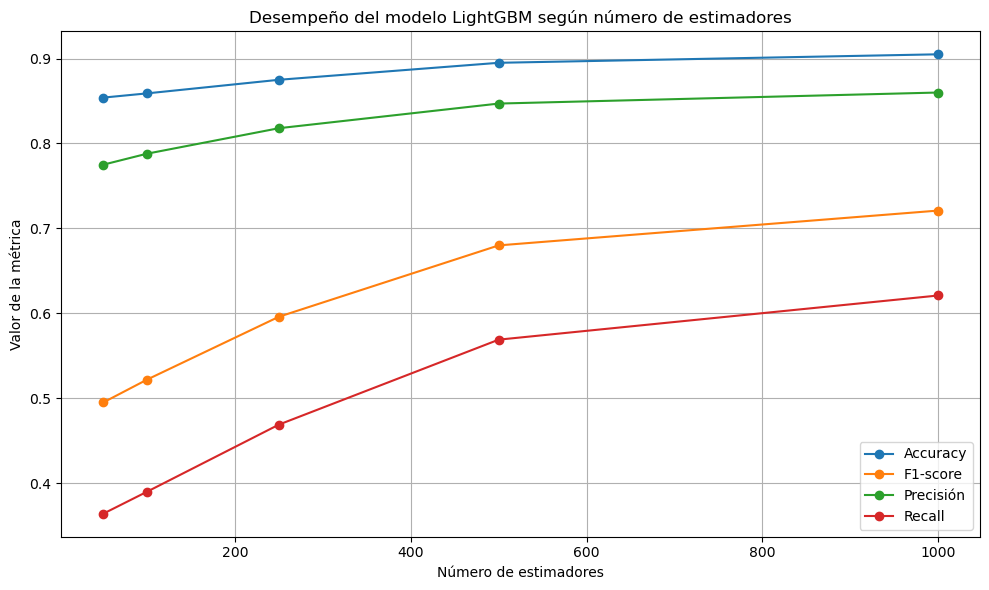

In [23]:
#Gráficas de Rendimiento
import matplotlib.pyplot as plt

# Datos del rendimiento del modelo para cada número de estimadores
estimadores = [50, 100, 250, 500, 1000]
accuracy = [0.854, 0.859, 0.875, 0.895, 0.905]
f1_score = [0.495, 0.522, 0.596, 0.680, 0.721]
precision = [0.775, 0.788, 0.818, 0.847, 0.860]
recall = [0.364, 0.390, 0.469, 0.569, 0.621]

# Crear gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(estimadores, accuracy, marker='o', label='Accuracy')
plt.plot(estimadores, f1_score, marker='o', label='F1-score')
plt.plot(estimadores, precision, marker='o', label='Precisión')
plt.plot(estimadores, recall, marker='o', label='Recall')

plt.title('Desempeño del modelo LightGBM según número de estimadores')
plt.xlabel('Número de estimadores')
plt.ylabel('Valor de la métrica')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
#MODELO 2: RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Lista de estimadores a probar
estimadores_rf = [50, 100, 250, 500, 1000]

# Lista para guardar los resultados
resultados_rf = []

for n in estimadores_rf:
    model_rf = RandomForestClassifier(n_estimators=n, max_depth=10, random_state=42)
    model_rf.fit(X_train, y_train)
    pred_rf = model_rf.predict(X_test)

    resultados_rf.append({
        'Número de estimadores': f'N={n}',
        'Accuracy': round(accuracy_score(y_test, pred_rf), 4),
        'F1_score': round(f1_score(y_test, pred_rf), 4),
        'Precision': round(precision_score(y_test, pred_rf), 4),
        'Recall': round(recall_score(y_test, pred_rf), 4)
    })

# Convertir a DataFrame para visualizar
df_resultados_rf = pd.DataFrame(resultados_rf)
print(df_resultados_rf)

  Número de estimadores  Accuracy  F1_score  Precision  Recall
0                  N=50    0.8439    0.3934     0.8450  0.2563
1                 N=100    0.8454    0.4021     0.8505  0.2633
2                 N=250    0.8449    0.3985     0.8500  0.2603
3                 N=500    0.8448    0.4001     0.8450  0.2621
4                N=1000    0.8455    0.4029     0.8503  0.2640


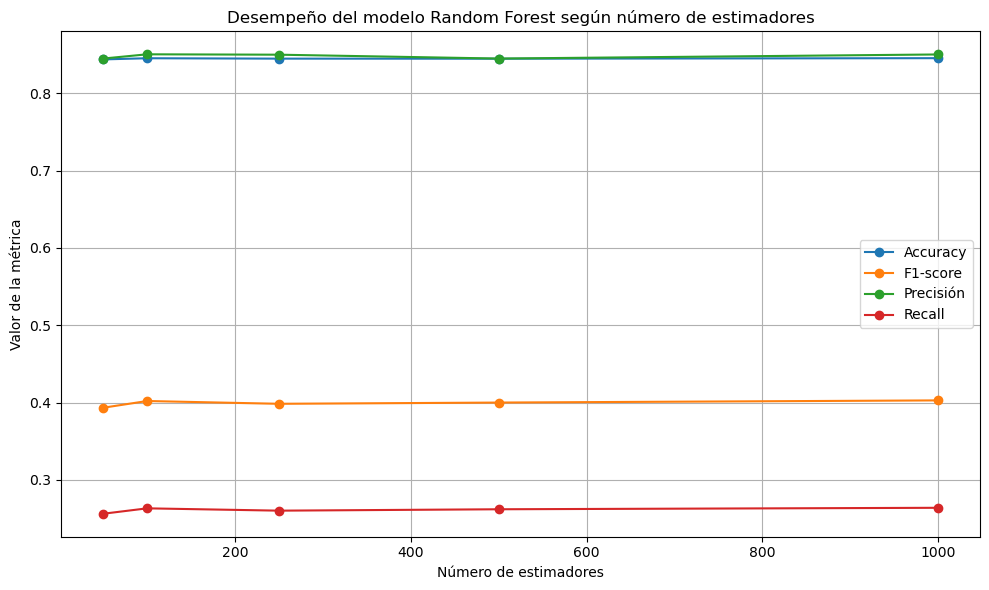

In [25]:
# Datos reales proporcionados por el usuario para Random Forest
estimadores_rf = [50, 100, 250, 500, 1000]
accuracy_rf = [0.8439, 0.8454, 0.8449, 0.8448, 0.8455]
f1_rf = [0.3934, 0.4021, 0.3985, 0.4001, 0.4029]
precision_rf = [0.8450, 0.8505, 0.8500, 0.8450, 0.8503]
recall_rf = [0.2563, 0.2633, 0.2603, 0.2621, 0.2640]

# Crear gráfico de líneas con los resultados reales
plt.figure(figsize=(10, 6))
plt.plot(estimadores_rf, accuracy_rf, marker='o', label='Accuracy')
plt.plot(estimadores_rf, f1_rf, marker='o', label='F1-score')
plt.plot(estimadores_rf, precision_rf, marker='o', label='Precisión')
plt.plot(estimadores_rf, recall_rf, marker='o', label='Recall')

plt.title('Desempeño del modelo Random Forest según número de estimadores')
plt.xlabel('Número de estimadores')
plt.ylabel('Valor de la métrica')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Valores de max_iter a probar
iteraciones = [50, 100, 250, 500, 1000]

# Guardar resultados
resultados_lr = []

for it in iteraciones:
    model_lr = LogisticRegression(max_iter=it, random_state=42)
    model_lr.fit(X_train, y_train)
    pred_lr = model_lr.predict(X_test)

    resultados_lr.append({
        'max_iter': f'{it}',
        'Accuracy': round(accuracy_score(y_test, pred_lr), 4),
        'F1_score': round(f1_score(y_test, pred_lr), 4),
        'Precision': round(precision_score(y_test, pred_lr), 4),
        'Recall': round(recall_score(y_test, pred_lr), 4)
    })

df_resultados_lr = pd.DataFrame(resultados_lr)
print(df_resultados_lr)

  max_iter  Accuracy  F1_score  Precision  Recall
0       50    0.8025    0.0000     0.0000  0.0000
1      100    0.8023    0.0004     0.1250  0.0002
2      250    0.8023    0.0007     0.1818  0.0004
3      500    0.8019    0.0011     0.1250  0.0005
4     1000    0.8022    0.0007     0.1429  0.0004


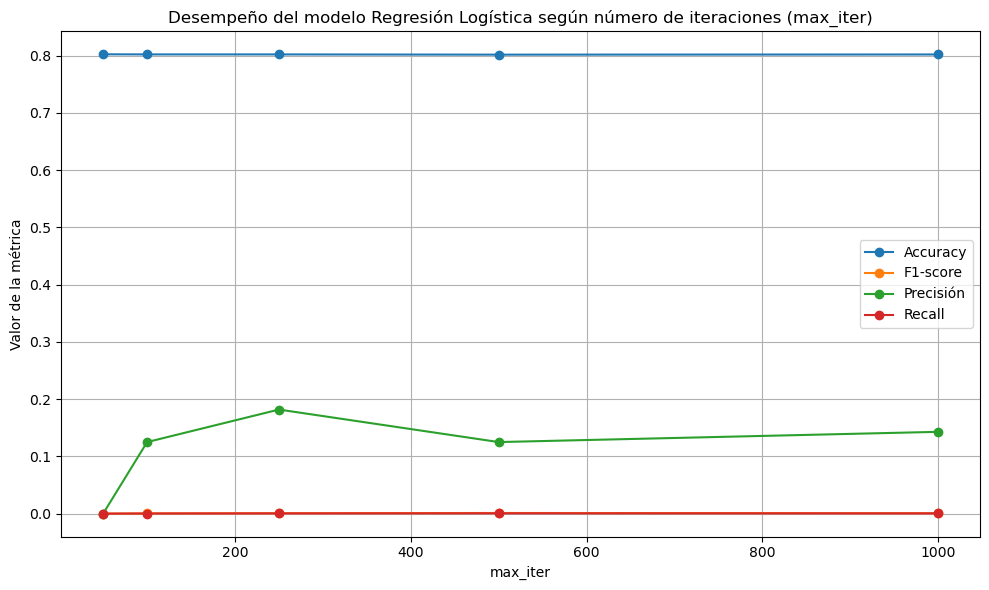

In [27]:
# Datos reales proporcionados por el usuario para Regresión Logística
iteraciones = [50, 100, 250, 500, 1000]
accuracy_lr = [0.8025, 0.8023, 0.8023, 0.8019, 0.8022]
f1_lr = [0.0, 0.0004, 0.0007, 0.0011, 0.0007]
precision_lr = [0.0, 0.1250, 0.1818, 0.1250, 0.1429]
recall_lr = [0.0, 0.0002, 0.0004, 0.0005, 0.0004]

# Crear gráfico de líneas con los resultados reales
plt.figure(figsize=(10, 6))
plt.plot(iteraciones, accuracy_lr, marker='o', label='Accuracy')
plt.plot(iteraciones, f1_lr, marker='o', label='F1-score')
plt.plot(iteraciones, precision_lr, marker='o', label='Precisión')
plt.plot(iteraciones, recall_lr, marker='o', label='Recall')

plt.title('Desempeño del modelo Regresión Logística según número de iteraciones (max_iter)')
plt.xlabel('max_iter')
plt.ylabel('Valor de la métrica')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Lista de estimadores a evaluar
estimadores_xgb = [50, 100, 250, 500, 1000]

# Lista para guardar resultados
resultados_xgb = []

for n in estimadores_xgb:
    model_xgb = XGBClassifier(n_estimators=n, use_label_encoder=False, eval_metric="logloss", random_state=42)
    model_xgb.fit(X_train, y_train)
    pred_xgb = model_xgb.predict(X_test)

    resultados_xgb.append({
        'Número de estimadores': f'N={n}',
        'Accuracy': round(accuracy_score(y_test, pred_xgb), 4),
        'F1_score': round(f1_score(y_test, pred_xgb), 4),
        'Precision': round(precision_score(y_test, pred_xgb), 4),
        'Recall': round(recall_score(y_test, pred_xgb), 4)
    })

# Convertir a DataFrame para ver resultados
df_resultados_xgb = pd.DataFrame(resultados_xgb)
print(df_resultados_xgb)


  Número de estimadores  Accuracy  F1_score  Precision  Recall
0                  N=50    0.8566    0.5229     0.7623  0.3979
1                 N=100    0.8679    0.5784     0.7821  0.4589
2                 N=250    0.8888    0.6703     0.8086  0.5724
3                 N=500    0.9018    0.7181     0.8290  0.6334
4                N=1000    0.9028    0.7207     0.8325  0.6353


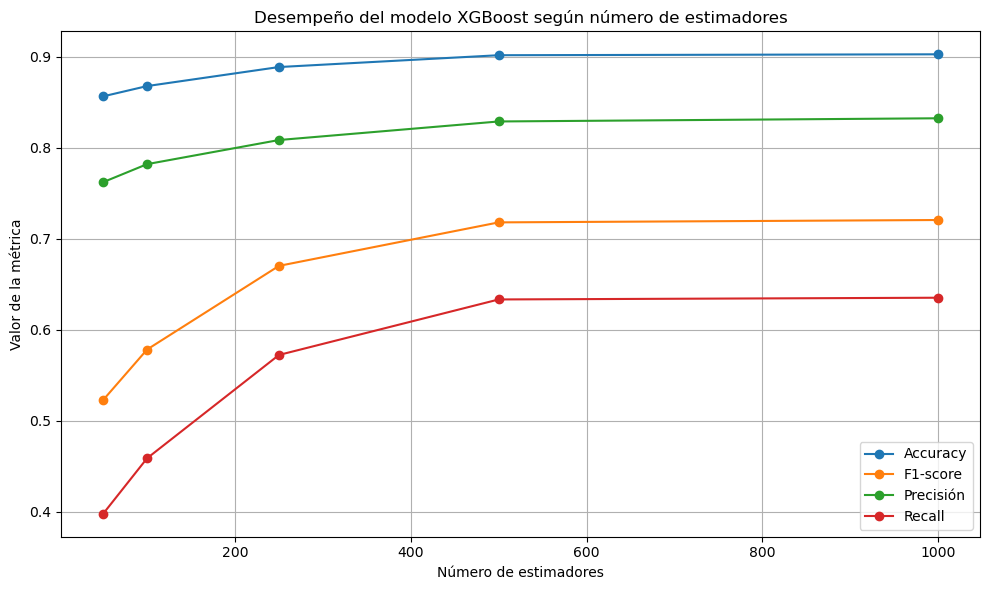

In [29]:
# Datos reales proporcionados por el usuario para XGBoost
estimadores_xgb = [50, 100, 250, 500, 1000]
accuracy_xgb = [0.8566, 0.8679, 0.8888, 0.9018, 0.9028]
f1_xgb = [0.5229, 0.5784, 0.6703, 0.7181, 0.7207]
precision_xgb = [0.7623, 0.7821, 0.8086, 0.8290, 0.8325]
recall_xgb = [0.3979, 0.4589, 0.5724, 0.6334, 0.6353]

# Crear gráfico de líneas con los resultados reales
plt.figure(figsize=(10, 6))
plt.plot(estimadores_xgb, accuracy_xgb, marker='o', label='Accuracy')
plt.plot(estimadores_xgb, f1_xgb, marker='o', label='F1-score')
plt.plot(estimadores_xgb, precision_xgb, marker='o', label='Precisión')
plt.plot(estimadores_xgb, recall_xgb, marker='o', label='Recall')

plt.title('Desempeño del modelo XGBoost según número de estimadores')
plt.xlabel('Número de estimadores')
plt.ylabel('Valor de la métrica')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
from lightgbm import LGBMClassifier, early_stopping
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import optuna
import pandas as pd

# =============================================
# 1. LightGBM con hiperparámetros óptimos de Optuna
# =============================================
best_params = {
    'learning_rate': 0.09972667854831817,
    'max_depth': 23,
    'num_leaves': 60,
    'min_child_samples': 23,
    'feature_fraction': 0.8549754396255432,
    'subsample': 0.847060082911702,
    'subsample_freq': 3,
    'reg_alpha': 0.30099561997132496,
    'reg_lambda': 0.547277085001394,
    'n_estimators': 1000,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'random_state': 42
}

model_lgbm = LGBMClassifier(**best_params)
model_lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[early_stopping(stopping_rounds=200)]
)
pred_lgbm = model_lgbm.predict(X_test)
report_lgbm = classification_report(y_test, pred_lgbm, output_dict=True)

# =============================================
# 2. Random Forest
# =============================================
model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)
report_rf = classification_report(y_test, pred_rf, output_dict=True)

# =============================================
# 3. Logistic Regression
# =============================================
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)
report_lr = classification_report(y_test, pred_lr, output_dict=True)

# =============================================
# 4. XGBoost
# =============================================
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)
report_xgb = classification_report(y_test, pred_xgb, output_dict=True)

[LightGBM] [Warning] feature_fraction is set=0.8549754396255432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8549754396255432
[LightGBM] [Warning] feature_fraction is set=0.8549754396255432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8549754396255432
[LightGBM] [Info] Number of positive: 13292, number of negative: 52811
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12757
[LightGBM] [Info] Number of data points in the train set: 66103, number of used features: 78
[LightGBM] [Warning] feature_fraction is set=0.8549754396255432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8549754396255432
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201080 -> initscore=-1.379557
[LightGBM] [Info] Start training from score -1.379557
Training until validation scores don't impr

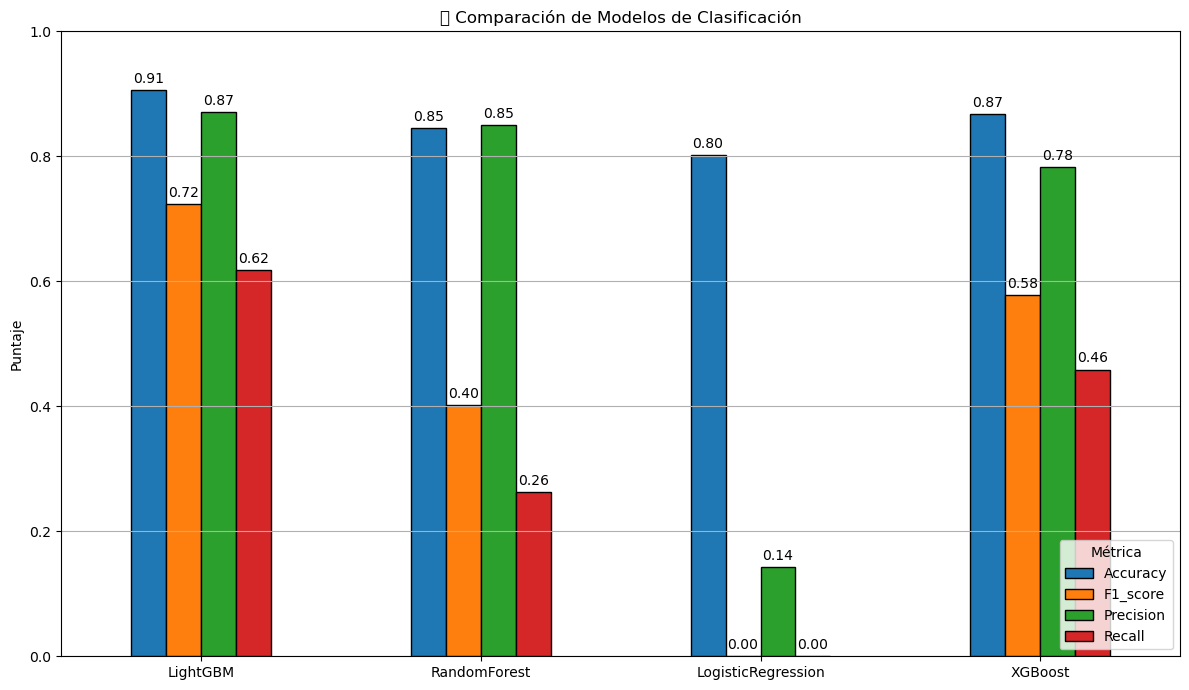

In [35]:
# Diccionario con métricas reales 
metrics_summary = {
    "LightGBM": {
        "Accuracy": report_lgbm["accuracy"],
        "F1_score": report_lgbm["weighted avg"]["f1-score"],
        "Precision": report_lgbm["weighted avg"]["precision"],
        "Recall": report_lgbm["weighted avg"]["recall"]
    },
    "RandomForest": {
        "Accuracy": report_rf["accuracy"],
        "F1_score": report_rf["weighted avg"]["f1-score"],
        "Precision": report_rf["weighted avg"]["precision"],
        "Recall": report_rf["weighted avg"]["recall"]
    },
    "LogisticRegression": {
        "Accuracy": report_lr["accuracy"],
        "F1_score": report_lr["weighted avg"]["f1-score"],
        "Precision": report_lr["weighted avg"]["precision"],
        "Recall": report_lr["weighted avg"]["recall"]
    },
    "XGBoost": {
        "Accuracy": report_xgb["accuracy"],
        "F1_score": report_xgb["weighted avg"]["f1-score"],
        "Precision": report_xgb["weighted avg"]["precision"],
        "Recall": report_xgb["weighted avg"]["recall"]
    }
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics_summary).T

# Gráfico
ax = metrics_df.plot(kind="bar", figsize=(12, 7), edgecolor='black')
plt.title("📊 Comparación de Modelos de Clasificación")
plt.ylabel("Puntaje")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.legend(loc="lower right", title="Métrica")

# Añadir etiquetas a cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()



In [36]:
import pickle

# Define el nombre del archivo
filename = "modelo_lightgbm_final.pkl"

# Guarda el modelo entrenado
with open(filename, "wb") as f:
    pickle.dump(model_lgbm, f)

print(f"✅ Modelo guardado como '{filename}'")

✅ Modelo guardado como 'modelo_lightgbm_final.pkl'
